# 生成数据

In [143]:
from sklearn import datasets

# 在2D中生成一个包含较小圆的大圆的样本集
def getTwoCircles(n_samples):
    X,y = datasets.make_circles(n_samples, factor=0.5, noise=0.05)
    return X,y

# 1 构图

### 1.1 构建距离矩阵

In [144]:
import numpy as np

#定义欧式距离
def euclidDistance(x1, x2, sqrt_flag=False):
    res = np.sum((x1-x2)**2)
    if sqrt_flag:
        res = np.sqrt(res)
    return res
 
def calEuclidDistanceMatrix(X):
    X = np.array(X)
    S = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            S[i][j] = 1.0 * euclidDistance(X[i], X[j])
            S[j][i] = S[i][j]
    return S

### 1.2 构造近邻矩阵

In [145]:
'''
KNN算法：
  如果一个样本在特征空间中的K个最相似（即特征空间中最邻近）的样本中的大多数
  属于某一个类别，则该样本也属于这个类别。
  该方法在定类决策上只依据最邻近的一个或者几个样本的类别
  来决定待分样本所属的类别
'''
import numpy as np
 
def myKNN(S, k, sigma=1.0):
    N = len(S)
    #返回矩阵的行数
    A = np.zeros((N,N))
    #下为找xi的K邻近
    for i in range(N):
        dist_with_index = zip(S[i], range(N))
        #矩阵的第i行各个元素，与长度为数字N的tuple（元组）集合，组成列表
        #[(ai1,0),(ai2,1),,,]
        dist_with_index = sorted(dist_with_index, key=lambda x:x[0])
        #按列表的第一个元素升序排列
        neighbours_id = [dist_with_index[m][1] for m in range(k+1)] 
        # xi's k-nearest neighbours
        #返回K邻近的列坐标
        for j in neighbours_id: # xj is xi's neighbour
            A[i][j] = np.exp(-S[i][j]/2/sigma/sigma)
            #高斯核函数:随着两个向量的距离增大，高斯核函数单调递减
            #np.exp=e^x
            A[j][i] = A[i][j] # mutually
    return A
'''
 A是各个样本的K邻近矩阵，维度:n*n,K邻近有值，其余为0
'''

'\n A是各个样本的K邻近矩阵，维度:n*n,K邻近有值，其余为0\n'

### 1.3 构建标准化的拉普拉斯矩阵L=D-W

In [146]:
import numpy as np
 
def calLaplacianMatrix(adjacentMatrix):
 
    # compute the Degree Matrix: D=sum(A)
    degreeMatrix = np.sum(adjacentMatrix, axis=1)
 
    # print degreeMatrix
 
    # compute the Laplacian Matrix: L=D-A
    laplacianMatrix = np.diag(degreeMatrix) - adjacentMatrix
    #np.diag:以一维数组的形式返回方阵的对角线
    # print laplacianMatrix
 
    # normailze
    # D^(-1/2) L D^(-1/2)
    sqrtDegreeMatrix = np.diag(1.0 / (degreeMatrix ** (0.5)))
    #**:返回x的y次幂
    return np.dot(np.dot(sqrtDegreeMatrix, laplacianMatrix), sqrtDegreeMatrix) 
    #np.dot:矩阵乘法


# 2 切图

### 2.1 特征值分解、K-means

In [147]:
from matplotlib import pyplot as plt
from itertools import cycle, islice
import numpy as np
 
from matplotlib.pyplot import title
 
def plot(X, y, title):
    colors = np.array(list(islice(
        cycle(['#4daf4a', '#ff7f00']),
        int(max(y) + 1))))
    plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y])
    plt.savefig(str(title)+".png")

TypeError: scatter() missing 1 required positional argument: 'y'

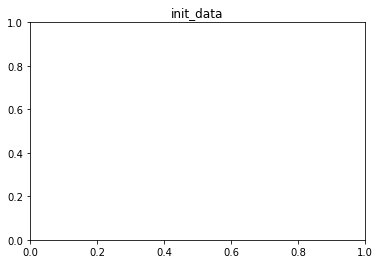

In [153]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np
 
np.random.seed(1)
'''
 seed( ) 用于指定随机数生成时所用算法开始的整数值。
 1.如果使用相同的seed( )值，则每次生成的随即数都相同；
 2.如果不设置这个值，则系统根据时间来自己选择这个值，
   此时每次生成的随机数因时间差异而不同。
 3.设置的seed()值仅一次有效
'''
 
data, label = getTwoCircles(n_samples=100)
# 返回data(生成的样本)；label(每个样本的类成员的整数标签0或1)
 
Similarity = calEuclidDistanceMatrix(data)
# 返回Similarity(样本距离矩阵)N*N
 
Adjacent = myKNN(Similarity, k=4)
# 返回A(K邻近矩阵)N*N，将距离转为相似度，K邻近有值，其余为0
Laplacian = calLaplacianMatrix(Adjacent)
# Laplacian:返回拉普拉斯算子运算D^(-1/2) L D^(-1/2)
x, V = np.linalg.eig(Laplacian)
# 计算方形矩阵Laplacian的特征值和特征向量
# x多个特征值组成的一个矢量
# V多个特征向量组成的一个矩阵。
# 每一个特征向量都被归一化了。
# 第i列的特征向量v[:,i]对应第i个特征值x[i]。
x = zip(x, range(len(x)))
# 特征值与序号组成列表
x = sorted(x, key=lambda x: x[0])
# 按列表的第一个元素(特征值)升序排列
H = np.vstack([V[:, i] for (v, i) in x[:100]]).T
# 取最小的100个特征值对应的特征行向量
# 按垂直方向（行顺序）堆叠数组构成一个新的数组,然后转置
kmeans = KMeans(n_clusters=2).fit(data)
# 使用原始数据训练KMeans，聚类为2簇
sp_kmeans = KMeans(n_clusters=2).fit(H)
# 使用H训练KMeans，聚类为2簇
name = ['spectral_clustering','kmeans_clustering']
plot(data, kmeans.labels_, name[1])
plot(data, sp_kmeans.labels_, name[0])
# 画图进行比较
